# Lecture 30: Regularization



[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:


# Run this cell to set up your notebook
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.set_context("talk")

import plotly.express as px 

from IPython.display import display, Latex, Markdown

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection




We just saw how cross-validation can help find a dimension for a fitted model that balances under- and overfitting. Rather than selecting the dimension of the model, we can build a model with all of the features, but restrict the size of the coefficients. We keep from overfitting by adding to the MSE a penalty term on the size of the coefficients. The penalty, called a *regularization term*, is $ \alpha$.   We fit the model by minimizing the combination of mean squared error plus this penalty:


When the *regularization parameter*, $\alpha$, is large, it penalizes large coefficients.
(We typically choose it by cross-validation.) 

A popular regularization is called *lasso regression* (lasso stands for Least Absolute Shrinkage and Selection Operator). It penalizes the absolute size of the coefficients: 

$$
\begin{aligned}
\frac{1}{n} \sum_{i=1}^{n}(y_i - \mathbf{x}_i \boldsymbol{\theta})^2  ~+~ \alpha \sum_{j = 1}^{p} |\theta_j|
\end{aligned}
$$

 
To get an idea about how regularization works, let's think about the extreme cases: when $ \alpha $ is really large and when it's close to 0 ($ \alpha $ is never negative). With a big regularization parameter, the coefficients are heavily penalized, so they shrink. On the other hand, when $ \alpha $ is tiny, the coefficients aren't restricted. In fact, when $ \alpha $ is 0, we're back in the world of ordinary least squares. A couple of issues crop up when we think about controlling the size of the coefficients through regularization: 
 
+ We do not want to regularize the intercept term. This way, a large penalty fits a constant model.
+ When features have very different scales, the penalty can impact them differently, with large-valued features being penalized more than others. To avoid this, we standardize all of the features to have mean 0 and variance 1 before fitting the model.


Using regularization allows us to avoid model overfitting by penalizing large coefficients.  $ L_1 $ regularization has the advantage of zeroing out coefficients; it performs *feature selection* by discarding the features with a coefficient of 0. This is particularly useful when working with high-dimensional data with many features. A model that only uses a few features to make a prediction runs much faster than a model that requires many calculations. Since unneeded features tend to increase model variance without decreasing bias, we can sometimes increase the accuracy of other models by using lasso regression to select a subset of features to use.

Let's look at an example with 35 features.

# Example: A Market Analysis

A [market research project](https://doi.org/10.1080/02664763.2014.994480) for a pharmaceutical company wants to model consumer interest in purchasing a cold sore health-care product. They gather data from 1,023 consumers. Each consumer is asked to rate on a 10-point scale 35 factors according to whether the factor matters to them when considering purchasing a cold sore treatment. They also rate their interest in purchasing the product. 

Stan Lipovetsky and W. Michael Conklin (2015) Predictor relative importance
and matching regression parameters. _Journal of Applied Statistics_, 42:5, 1017-1031.

We begin by reading in the data:

In [2]:
ma_df = pd.read_csv('data/market-analysis.csv')



The table below lists the 35 factors and provides their correlation to the outcome, their interest in purchasing the product. 




|  | Corr | Description |  | Corr | Description |
| --- | --- | --------- | --- | --- | --------- |
| x1  | 0.70 | provides soothing relief | x19 | 0.54 | has a non-messy application |
| x2  | 0.58 | moisturizes cold sore blister | x20 | 0.70 | good for any stage of a cold |
| x3  | 0.69 | provides long-lasting relief | x21 | 0.49 | easy to apply/take |
| x4  | 0.70 | provides fast-acting relief | x22 | 0.52 | package keeps from contamination |
| x5 | 0.72 | shortens duration of a cold | x23 | 0.57 | easy to dispense a right amount |
| x6  | 0.68 | stops the virus from spreading | x24 | 0.63 | worth the price it costs |
| x7 | 0.67| dries up cold sore | x25 | 0.57 | recommended most by pharamacists |
| x8 | 0.72 | heals fast | x26 | 0.54 | recommended by doctors |
| x9 | 0.72 | penetrates deep | x27 | 0.54 | FDA approved |
| x10 | 0.65 | relieves pain | x28 | 0.64 | a brand I trust |
| x11 |0.61 | prevents cold | x29 | 0.60 | clinically proven |
| x12 | 0.73 | prevents from getting worse | x30 | 0.68 | a brand I would recommend |
| x13 | 0.57 | medicated | x31 | 0.74 | an effective treatment |
| x14 | 0.61 | prescription strength | x32  |0.37 | portable |
| x15 | 0.63 | repairs damaged skin | x33 | 0.37 | discreet packaging |
| x16 | 0.67 | blocks virus from spreading | x34 | 0.55 | helps conceal cold sores |
| x17 | 0.42 | contains SPF | x35 | 0.63 | absorbs quickly |
| x18 | 0.57 | non-irritating | | | |

:::

<AxesSubplot:>

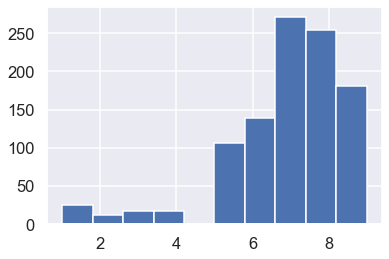

In [3]:
ma_df["y"].hist()

Based on their labels alone, some of these 35 features appear to measure similar aspects of desirability. We can compute the correlations between the explanatory variables to confirm this: 

In [4]:
ma_df.corr().head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35
y,1.000000,0.698082,0.584470,0.689198,0.698104,0.715737,0.675171,0.674324,0.720245,0.715239,...,0.543472,0.535300,0.643565,0.599936,0.681561,0.744036,0.370732,0.365545,0.553436,0.627739
x1,0.698082,1.000000,0.693949,0.741297,0.806206,0.745964,0.733237,0.715636,0.764331,0.781493,...,0.545061,0.555448,0.669401,0.632966,0.675034,0.786363,0.420447,0.327813,0.573375,0.714993
x2,0.584470,0.693949,1.000000,0.632579,0.652231,0.629310,0.626027,0.606470,0.628247,0.667748,...,0.520121,0.535033,0.608308,0.600972,0.618307,0.658305,0.426040,0.355965,0.546330,0.631601
x3,0.689198,0.741297,0.632579,1.000000,0.775006,0.764568,0.781304,0.716138,0.795831,0.766581,...,0.559115,0.571977,0.634122,0.665531,0.635772,0.795528,0.366715,0.343737,0.667460,0.697526
x4,0.698104,0.806206,0.652231,0.775006,1.000000,0.791758,0.763113,0.742654,0.812947,0.782780,...,0.566515,0.550485,0.649257,0.628049,0.674396,0.816444,0.386155,0.316505,0.595784,0.715873


We see, for example, that the last feature, "absorbs quickly," is highly correlated with the first three: "provides soothing relief," "moisturizes," and "provides long-lasting relief."   

## Splitting into Training, Validation and Test Sets

Before we start to fit regularized models, we set up the design matrix and outcome vector and split the data into trainining, validation and test sets.  As usual we will only use the test set once (after selecting and fitting the model).

In [5]:
Y = ma_df["y"]
X = ma_df.drop(columns=["y"])


In [6]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)



# Further split train_val into training and validation (80/20)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=18)

print(f"Size of original set: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of original set: 1023 points
Size of training set: 654 points
Size of validation set: 164 points
Size of test set: 205 points


In [7]:
import sklearn.linear_model as lm


In [8]:
# Calculate RMSE:

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

## Using Regularization

### Converting Predictors to Standard Units



Before fitting a regularized model we need to get all of the predictors/features in standard units.

First, we'll standardize the training set, and then, when we go to evaluate the model on our validation set, we use the training set standardization on the validation-set. The [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method helps us with this process:

In [9]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) 
X_train_scaled = scalerX.transform(X_train)
X_val_scaled = scalerX.transform(X_val)

We confirm that the means of the 35 features in the train set are all 0 and the SDs are all&nbsp;1: 

In [10]:
np.allclose(X_train_scaled.mean(axis=0), 0)

True

In [11]:
np.allclose(X_train_scaled.std(axis=0), 1)

True

It's important to note that this is not the case for the validation (or test sets), because we
use the averages and SDs from the training set to standardize the test set features:

In [12]:
X_val_scaled.mean(axis=0)

array([ 0.02377406,  0.06529805, -0.00994611, -0.02704322, -0.07188061,
       -0.06868627,  0.05448175,  0.05305942,  0.01916184, -0.01528108,
       -0.09424118, -0.03031311,  0.05972178, -0.00192531, -0.04870533,
        0.00481807, -0.03680607,  0.06980319, -0.08446423,  0.00651155,
        0.0151777 ,  0.07392285, -0.02968198, -0.0267167 , -0.10021885,
       -0.00439202, -0.04895446,  0.05558286, -0.04992794, -0.00193848,
       -0.01544541,  0.07287351,  0.01440254, -0.05500454, -0.07052452])

## Lasso Regression 

To perform a lasso regression, we use the `Lasso` method in `scikit-learn`.  

In [49]:
from sklearn.linear_model import Lasso

# Suppose we randomly chose alpha = 0.25 **We'll see more below on how to best choose alpha

# General Syntax for Fitting Lasso model with parameter alpha:

model_25 = Lasso(0.25)
model_25.fit(X_train_scaled, Y_train)



Lasso(alpha=0.25)

In [50]:
model.coef_

array([0.1579859 , 0.        , 0.        , 0.01092742, 0.09332436,
       0.        , 0.05422644, 0.01478989, 0.13709191, 0.        ,
       0.        , 0.20097259, 0.08061656, 0.        , 0.17990008,
       0.        , 0.        , 0.        , 0.01819671, 0.        ,
       0.        , 0.        , 0.00444496, 0.        , 0.01682387,
       0.        , 0.        , 0.        , 0.        , 0.18887814,
       0.22482153, 0.        , 0.        , 0.        , 0.        ])

Notice this method automatically selects the "best" features/predictors (for the given alpha) and sets the others to zero.  This is a way of feature selection.

In [51]:
# Using model to predict 
y_pred = model_25.predict(X_val_scaled)

rmse(y_pred, Y_val)

0.9448519952486507

### Choosing Alpha:

### Some Visual Intuition

For demo/learning purposes only, let's see how the coefficients for the 35 features in the data frame change with $\alpha$. We set up a range of values for the regularization parameter and fit the lasso for each (this parameter is referred to as `alpha` in `Lasso`): 

In [52]:


coefs = []
rmses = []
alphas = np.arange(0.01, 1.5, 0.01)

for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X_train_scaled, Y_train)
    coefs.append(model.coef_)
    # We'll evaluate the validation RMSEs
    rmses.append(rmse(Y_val, model.predict(X_val_scaled)))

For each feature, we can overlay a line plot of the coefficient against $ \alpha $: 

In [55]:

col_names = ["x" + str(v) for v in np.arange(1, 36, 1)]

coefs_df = pd.DataFrame(coefs, columns=col_names)

coefs_df["alpha"] = alphas
coefs_long = pd.melt(coefs_df, id_vars=["alpha"], value_vars=col_names)


fig = px.line(coefs_long, x="alpha", y="value", color="variable", log_x=True)
fig.update_layout(
    showlegend=False, width=550, height=250, yaxis_title="Coefficient",
    xaxis_title="alpha"
)



As $ \alpha $ increases, the model fitting is penalized more heavily and many coefficients shrink to 0. The lefthand side of the plot shows greater model complexity and corresponds to small $ \alpha $. Notice that for $ \alpha = 0.5 $, nearly all of the coefficients are 0. 

We can also plot the RMSE as a function of $ \alpha $ to see how it changes with the increase in the penalty:

In [56]:
px.line(x=alphas, y=rmses,
        labels={"x": "alpha", "y": "Validation RMSE"},
        width=350, height=250)

When $ \alpha $ reaches about 1.35, the penalty is so large that the lasso regression is simply fitting a constant model to the data, and the RMSE doesn't change. We are again faced with a model selection question, but this time it's in the form of deciding on $ \alpha $. 


## Choosing alpha:  

### Option 1: Based on desired number of predictors:

If you're interested in creating a simple model with just a select number of important predictors you can choose the alpha that results in your chosen number of predictors.  For example, suppose we want a model with just 6 predictors.    We can see in the alpha vs coefficient plot above, that an alpha value around .80 will result in a model with 6 predictors.

In [17]:
model_80 = Lasso(alpha=.80)

model_80.fit(X_train_scaled, Y_train)



Lasso(alpha=0.8)

In [18]:
model_80.coef_


array([0.08129866, 0.        , 0.        , 0.        , 0.02805257,
       0.        , 0.        , 0.        , 0.13014408, 0.        ,
       0.        , 0.14671371, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02190631,
       0.2078129 , 0.        , 0.        , 0.        , 0.        ])

In [20]:
rmse(Y_val, model_80.predict(X_val_scaled))

1.2032771406883693

## Using Cross-Validation to Choose alpha:

If instead your goal is to find the "best" alpha that minimizes RMSE, we can use cross-validation to help us. 

We use the [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) method to perform 5-fold cross-validation to choose $\alpha$:

We'll use the full training_validation dataset (since Python knows we're using cross validation to help us with model selection (i.e. to help us choose alpha).  
So first we need to re-standardize using the full training_val set:

In [23]:
from sklearn.preprocessing import StandardScaler

scalerX_full = StandardScaler().fit(X_train_val) 
X_train_val_scaled = scalerX_full.transform(X_train_val)



In [ ]:
from sklearn.linear_model import LassoCV

#We'll choose alpha values between 0.01 and 1 based on our validation RMSE vs alpha plot above:)
lasso_cv_model = LassoCV(
    alphas=np.arange(0.01, 1, 0.01), cv=5)

In [24]:
lasso_best = lasso_cv_model.fit(X_train_val_scaled, Y_train_val)

Cross-validation has chosen the following regularization parameter:

In [25]:
lasso_best.alpha_

0.04

Let's find how many coefficients (out of the original 35) are not 0:

In [26]:
sum(np.abs(lasso_best.coef_) > 0)

18

View which features are included in this Lasso Regression model:

In [29]:
X_train_val.loc[:,np.abs(lasso_best.coef_) > 0].columns

Index(['x1', 'x5', 'x7', 'x8', 'x9', 'x11', 'x12', 'x13', 'x14', 'x15', 'x19',
       'x23', 'x25', 'x28', 'x30', 'x31', 'x33', 'x34'],
      dtype='object')

## Run Final Version of Model on Test Data

In [30]:
# Before running on the test set, we need to standardize the test data.
# We'll use the standardization we used on the training_val set:

X_test_scaled = scalerX_full.transform(X_test)

In [31]:
# RMSE from test set (only run this once at end!)
Y_test_pred = lasso_best.predict(X_test_scaled)
rmse(Y_test, Y_test_pred)

1.0989705839439465

### Peeking Under the Hood - Don't Try this at Home!

In [58]:
# DON'T TRY THIS AT HOME!
# We'll peek under the hood and see if this actually performs better on the test set than
# the OLS model using all the parameters.  

import sklearn.linear_model as lm

model_0 = lm.LinearRegression()

# Fit your linear model

model_0.fit(X_train_val, Y_train_val);



Y_test_pred_0 = model_0.predict(X_test)

In [59]:
rmse(Y_test, Y_test_pred_0)


1.1476383940071113

In [ ]:
# Yep!  Our regularized model is better!

## Other Types of Regularization

In the scope of our class, we're only covering Lasso (L1) Regularization.  However, other types exist (in paticular, L2 or Ridge regression is covered in the Appendix lesson slides).

Sometimes we prefer one type of regularization over the other because it maps more closely to the domain we are working with. For example, if we know that the phenomenon we are trying to model results from many small factors, we might prefer ridge regression because it won't discard these factors. On the other hand, some outcomes result from a few highly influential features. We prefer lasso regression in these situations because it discards unneeded features. Both $L_2$ and $L_1$ serve as useful throttles to navigate between under- and overfitting.



Regularization, train-test split, and cross-validation all have the goal of reducing over-fitting. The problem with over-fitting comes from using data to both fit a model and estimate the model's error in predicting new observations. In the next section, we provide further intuition for this idea.